In [96]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings('ignore', 'The behavior of `series.*`', FutureWarning)
warnings.filterwarnings('ignore', 'invalid value encountered', RuntimeWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import yfinance as yf
from datetime import datetime

import ta

In [97]:
# Load the Bitcoin price data
bitcoin_data = pd.read_csv(r'C:\Users\MrBios\Documents\Development\test\csv\bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
bitcoin_data.dropna(inplace=True)
bitcoin_data = bitcoin_data.tail(10000)
# drop nan values
bitcoin_data = bitcoin_data.dropna()

In [98]:
def add_indicators(df):
    # Calculate additional technical indicators using TA-Lib
    df["RSI"] = ta.momentum.rsi(bitcoin_data["Close"])
    df["MACD"] = ta.trend.macd(bitcoin_data["Close"])
    df["MACD_SIGNAL"] = ta.trend.macd_signal(bitcoin_data["Close"], fillna=True)
    df['MACD_diff'] = ta.trend.macd_diff(close=bitcoin_data["Close"], fillna=True)
    # bitcoin_data["OBV"] = ta.volume.on_balance_volume(close=bitcoin_data["Close"], volume=bitcoin_data["Volume_(BTC)"], fillna=True)
    return df
bitcoin_data = add_indicators(bitcoin_data)
bitcoin_data = bitcoin_data.dropna()

In [99]:
# bitcoin_data = add_all_ta_features(bitcoin_data,
#                                            open="Open",
#                                            high="High",
#                                            low="Low",
#                                            close="Close",
#                                            volume="Volume_(Currency)",
#                                            fillna=True)
# add RSI, MACD, MACD signal, MACD histogram
# bitcoin_data['RSI'] = ta.momentum.rsi(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['MACD'] = ta.trend.macd(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['MACD_signal'] = ta.trend.macd_signal(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['MACD_diff'] = ta.trend.macd_diff(close=bitcoin_data["Close"], fillna=True)
# bitcoin_data['SMA_20'] = ta.trend.sma_indicator(close=bitcoin_data["Close"], fillna=True)

In [100]:
# Prepare the data for training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(bitcoin_data[["Close", "RSI", "MACD", "MACD_SIGNAL", "MACD_diff"]])
scalers = {}  # Dictionary to store individual scalers for each feature


In [101]:
# Apply scaling for each feature separately
for i, feature in enumerate(["Close", "RSI", "MACD", "MACD_SIGNAL", "MACD_diff"]):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data[:, i] = scaler.fit_transform(bitcoin_data[[feature]]).flatten()
    scalers[feature] = scaler


In [102]:
# Create sequences of data with a given time step
time_step = 60
X = []
y = []
for i in range(time_step, len(scaled_data) - 30):
    X.append(scaled_data[i - time_step:i, :])
    y.append(scaled_data[i:i + 30, 0])
X = np.array(X)
y = np.array(y)

In [103]:
# Reshape X to match the expected input shape of the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))


In [104]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [105]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=30))


In [106]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [107]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
248/248 [==============================] - 8s 24ms/step - loss: 0.0287 - val_loss: 0.0018
Epoch 2/50
248/248 [==============================] - 6s 22ms/step - loss: 0.0067 - val_loss: 8.6628e-04
Epoch 3/50
248/248 [==============================] - 5s 22ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 4/50
248/248 [==============================] - 5s 22ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 5/50
248/248 [==============================] - 5s 22ms/step - loss: 0.0032 - val_loss: 7.1324e-04
Epoch 6/50
248/248 [==============================] - 5s 22ms/step - loss: 0.0027 - val_loss: 7.7293e-04
Epoch 7/50
248/248 [==============================] - 5s 22ms/step - loss: 0.0023 - val_loss: 8.4457e-04
Epoch 8/50
248/248 [==============================] - 5s 22ms/step - loss: 0.0022 - val_loss: 6.7284e-04
Epoch 9/50
248/248 [==============================] - 5s 22ms/step - loss: 0.0020 - val_loss: 8.2896e-04
Epoch 10/50
248/248 [==============================] - 5s 22ms/step

In [108]:
# Make predictions
predictions = model.predict(X_test)

62/62 [==============================] - 1s 7ms/step


In [109]:
# Scale the predictions back to original values for each feature
predictions_inverse = np.zeros_like(predictions)
for i, feature in enumerate(["Close", "RSI", "MACD", "MACD_SIGNAL", "MACD_diff"]):
    scaler = scalers[feature]
    predictions_inverse[:, i] = scaler.inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()

In [110]:
# predictions_inverse = scaler.inverse_transform(predictions)


In [111]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.025191473013996924


In [112]:
# now = datetime.now()
# format_date = now.strftime("%Y-%m-%d-%H-%M")
# model.save(f'models/1-v4-model_{format_date}.h5')
# model.save_weights(f'models/1-v4-weights_{format_date}.h5')
# # model.load_weights('v4-weights.h5')
# # model.load_model('v4-model.h5')

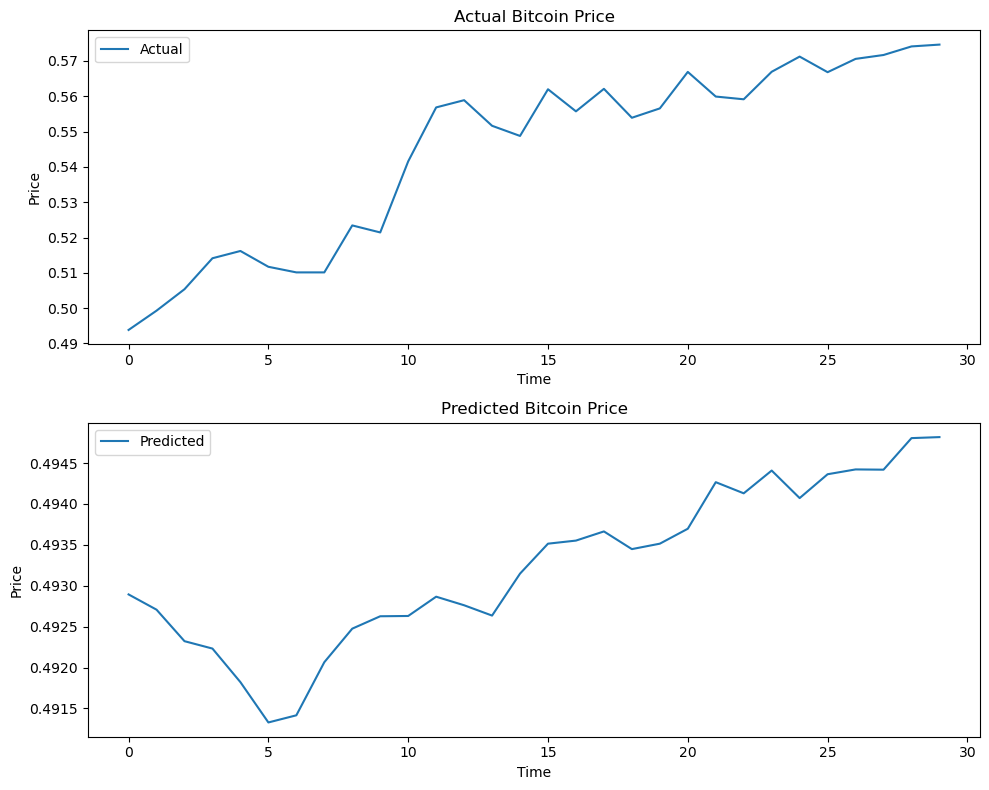

In [114]:
# Create two separate subplots for actual and predicted values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot the actual values
ax1.plot(y_test[0], label='Actual')
ax1.set_title('Actual Bitcoin Price')
ax1.set_xlabel('Time')
ax1.set_ylabel('Price')
ax1.legend()

# Plot the predicted values
ax2.plot(predictions[0], label='Predicted')
ax2.set_title('Predicted Bitcoin Price')
ax2.set_xlabel('Time')
ax2.set_ylabel('Price')
ax2.legend()

# Format the tick labels to display numbers in regular format
ax1.get_yaxis().get_major_formatter().set_useOffset(False)
ax2.get_yaxis().get_major_formatter().set_useOffset(False)

# Display the plot
plt.tight_layout()
plt.show()


In [117]:
# downloade the data with yfinance, get the last 2 hours
last_60_minutes = yf.download(tickers='BTC-USD', period='2h', interval='1m')

[*********************100%***********************]  1 of 1 completed


In [119]:

# 2. Scale the data to be values between 0 and 1
last_60_minutes_scaled = scaler.fit_transform(last_60_minutes[["Close"]])
# 3. Reshape the data into the shape accepted by the LSTM model
last_60_minutes_scaled = np.reshape(last_60_minutes_scaled, (1, last_60_minutes_scaled.shape[0], 1)) # cannot reshape array of size 60 into shape (1,1,1)


In [121]:
last_60_minutes_scaled  = add_indicators(last_60_minutes_scaled)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [120]:
pred = model.predict(last_60_minutes_scaled)


InvalidArgumentError: Graph execution error:

Detected at node 'while/MatMul' defined at (most recent call last):
    File "c:\Users\MrBios\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\MrBios\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 1041, in launch_instance
      app.start()
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 724, in start
      self.io_loop.start()
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\MrBios\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\MrBios\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\MrBios\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 512, in dispatch_queue
      await self.process_one()
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 501, in process_one
      await dispatch(*args)
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 408, in dispatch_shell
      await result
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 731, in execute_request
      reply_content = await reply_content
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 417, in do_execute
      res = shell.run_cell(
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\MrBios\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\MrBios\AppData\Local\Temp\ipykernel_26612\159223110.py", line 6, in <module>
      pred = model.predict(last_60_minutes_scaled)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\layers\rnn\base_rnn.py", line 556, in __call__
      return super().__call__(inputs, **kwargs)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\layers\rnn\lstm.py", line 748, in call
      ) = lstm_with_backend_selection(**normal_lstm_kwargs)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\layers\rnn\lstm.py", line 1338, in lstm_with_backend_selection
      last_output, outputs, new_h, new_c, runtime = defun_standard_lstm(
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\layers\rnn\lstm.py", line 980, in standard_lstm
      last_output, outputs, new_states = backend.rnn(
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\backend.py", line 5169, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\backend.py", line 5148, in _step
      output, new_states = step_function(
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\layers\rnn\lstm.py", line 966, in step
      z = backend.dot(cell_inputs, kernel)
    File "c:\Users\MrBios\anaconda3\lib\site-packages\keras\backend.py", line 2464, in dot
      out = tf.matmul(x, y)
Node: 'while/MatMul'
Matrix size-incompatible: In[0]: [1,1], In[1]: [5,200]
	 [[{{node while/MatMul}}]]
	 [[sequential_5/lstm_15/PartitionedCall]] [Op:__inference_predict_function_226759]

In [ ]:
pred = scaler.inverse_transform(pred)